In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

import shutup
shutup.please()

import jax
import jax.numpy as jnp

import numpy as np

# VIS
import matplotlib
import matplotlib.pyplot as plt
from rich.pretty import pprint
from tqdm.auto import tqdm

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

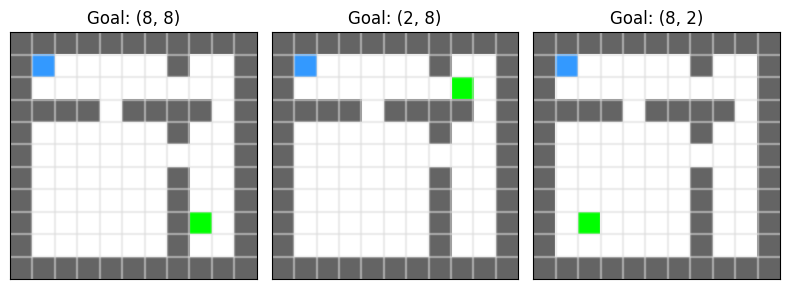

In [2]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze(seed=0, maze_type='fourrooms_random_layouts'))
test.reset()
img = test.render(return_img=True)
START_POS = (1,1)

fig, ax = plt.subplots(nrows=1, ncols=3)
for i, cur_ax in enumerate(ax.flat, start=0):
    test.setup_goals(seed=None, task_num=i, start_pos=START_POS)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()


# Collect Data

  0%|          | 0/10 [00:00<?, ?it/s]

{
│   'actions': (100000,),
│   'layout_type': (100000, 10),
│   'next_observations': (100000, 2),
│   'observations': (100000, 2),
│   'terminals': (100000,)
}

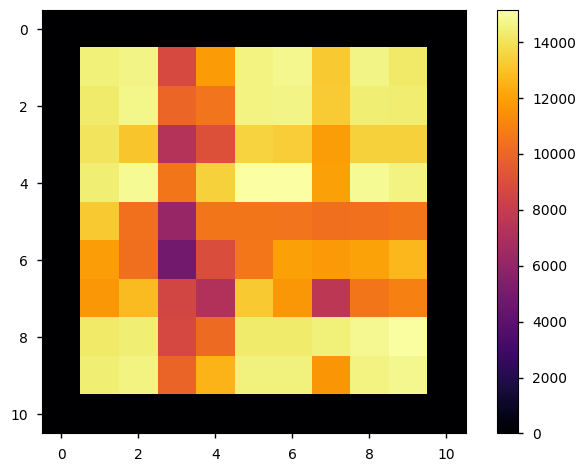

In [3]:
from envs.minigrid.env_utils import random_exploration_fourrooms, q_learning_fourrooms

train_layout_data = []
NUM_TRAIN_LAYOUTS = 10
NUM_TRAIN_STEPS = 100
NUM_TRAIN_EPISODES = 1000
seeds = np.arange(0, NUM_TRAIN_LAYOUTS)

for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
    env = FourRoomsMazeEnv(Maze(seed=seeds[i], maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
    dataset, env = random_exploration_fourrooms(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS, start_pos=None)
    train_layout_data.append(dataset)
    
pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

coverage_map = np.zeros(shape=env.maze.size)
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.savefig('coverage.svg', dpi=300)
plt.show()

# Initialize BFB

In [4]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_dynamics_discrete_4rooms.yaml',
                                                            f'agent.number_of_meta_envs={NUM_TRAIN_LAYOUTS}',
                                                            f'agent.discount=0.99',
                                                            f'agent.z_dim=150',
                                                            f'agent.output_dim=128',
                                                            f'agent.z_mix_ratio=0.5'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
# SAVING
# np.save(f"../aux_data/fourrooms_meta{NUM_TRAIN_LAYOUTS}_data", arr=jax.device_get(whole_data))
# whole_data = np.load(f"/home/m_bobrin/ZeroShotRL/aux_data/fourrooms_meta{NUM_TRAIN_LAYOUTS}_data.npy", allow_pickle=True).item()

print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 42,
│   'run_group': 'dynamics_fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 200001,
│   'log_interval': 10000,
│   'eval_interval': 30000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'dynamics_fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 150,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [1024, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'use_context': True,
│   │   'number_of_meta_envs': 10,
│   │   'dyn_encoder_warmup_steps': 80000,
│   │   'n_blocks': 4,
│   │   'n_heads': 4,
│   │   'emb_dim': 96,
│   │   'mlp_dim': 256,
│   │   'output_dim': 128,
│   │   'context_len': 100,
│   │   'use_masked_attention': False,
│   │   'use_mean_embedding': True,
│   │   'cosine_schedule': False,
│   │   'world_pred_hidden': [256, 256, 256],
│   │   'num_eval_episodes': 20
│   },
│   'env': {'env_name': 'fourrooms-dynamics', 'discrete': True},
│   'tags': ['dynamics-fb', '4rooms', 'discrete']
}

{'actions': (1000000,), 'layout_type': (1000000, 10), 'next_observations': (1000000, 2), 'observations': (1000000, 2), 'terminals': (1000000,)}


In [5]:
sys.path.append("..")
from agents.dynamics_fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
batch = gc_whole_dataset.sample(2, layout_type=0, context_length=NUM_TRAIN_STEPS)[1]
fb_agent, info = fb_agent.update(batch, train_context_embedding=True)

2025-05-22 23:15:42.100462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-22 23:15:43.260287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-22 23:15:43.281830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 23:15:45.139878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from envs.custom_mazes.env_utils import policy_image_fourrooms, value_image_fourrooms, plot_policy, get_canvas_image,\
    plot_value_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng
from IPython.display import clear_output

from envs.env_utils import EpisodeMonitor
from utils.evaluation import evaluate_fourrooms_dynamics
from collections import defaultdict
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from functools import partial
import jax

def policy_image_fourrooms(env, dataset, N, M, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, N, M, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    # plt.savefig("dynamics_fb.svg", dpi=300)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def value_image_fourrooms(env, dataset, value_fn, N, M, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_fourrooms(env, dataset, value_fn, N, M, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    # plt.savefig("dynamics_value.svg", dpi=300)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

START_POS = (1,1)
def visualize_value_image(env, layout_type, task_num):
    observation, info = env.setup_goals(seed=None, task_num=task_num, start_pos=START_POS)
    goal = info.get("goal_pos", None)
    mdp_type=None
    if fb_config['agent']['use_context']:
        dataset_inference, env = random_exploration_fourrooms(env, num_episodes=1, layout_type=layout_type, num_mdp=NUM_TRAIN_LAYOUTS, start_pos=START_POS)
        print(jax.tree.map(lambda x: x.shape, dataset_inference))
        dynamics_embedding_mean, dynamics_mean_std = fb_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None, :, None],
                                                                                    dataset_inference['next_observations'][None], train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
        dynamics_embedding = dynamics_embedding.squeeze()

    latent_z = jax.device_get(fb_agent.infer_z(goal, mdp_num=None, dynamics_embedding=dynamics_embedding)[None])
    N, M = env.maze.size
    pred_value_img = value_image_fourrooms(env, example_batch,N=N, M=M,
                                value_fn=partial(fb_agent.predict_q, z=latent_z, mdp_num=mdp_type[None] if mdp_type is not None else None,
                                                dynamics_embedding=dynamics_embedding[None]),
                                action_fn=None, goal=goal)
    return pred_value_img

def visualize_policy(env, layout_type, task_num):
    observation, info = env.setup_goals(seed=None, task_num=task_num, start_pos=START_POS)
    goal = info.get("goal_pos", None)
    if fb_config['agent']['use_context']:
        dataset_inference, env = random_exploration_fourrooms(env, num_episodes=1, layout_type=layout_type, num_mdp=NUM_TRAIN_LAYOUTS, start_pos=START_POS)
        print(jax.tree.map(lambda x: x.shape, dataset_inference))
        dynamics_embedding_mean, dynamics_mean_std = fb_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None,:,None],
                                                                                    dataset_inference['next_observations'][None], train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
        dynamics_embedding=dynamics_embedding.squeeze()
        mdp_type=None
        
    latent_z = fb_agent.infer_z(goal, mdp_num=mdp_type, dynamics_embedding=dynamics_embedding)
    # start = info.get("start_pos", None)
    example_batch = whole_dataset.sample(1)
    mdp_type=None
    N, M = env.maze.size
    pred_policy_img = policy_image_fourrooms(env, example_batch, N=N, M=M,
                                                    action_fn=partial(supply_rng(fb_agent.sample_actions,
                                                                                rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z,
                                                                    mdp_num=None, dynamics_embedding=dynamics_embedding[None], temperature=0.0),
                                                    goal=goal)
    return pred_policy_img

training_steps = 200_001
pbar = tqdm(range(training_steps))
eval_history_train = []
eval_history_test = []

PRETRAIN_ENCODER_STEPS = 50_000 # number of steps to train contexual transformer

for update_step in pbar:
    batch = gc_whole_dataset.sample(fb_config['agent']['batch_size'], layout_type=None, context_length=NUM_TRAIN_STEPS, get_traj_batch=True)[1]
    fb_agent, info = fb_agent.update(batch, train_context_embedding=True if update_step < PRETRAIN_ENCODER_STEPS else False)
    
    if update_step > PRETRAIN_ENCODER_STEPS and update_step % 30_000 == 0:
        clear_output()
        # TRAIN eval
        env = FourRoomsMazeEnv(Maze(seed=4, maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
        pred_policy_img = visualize_policy(env, layout_type=0, task_num=3)
        
        ax[0, 0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(env, layout_type=0, task_num=3)
        ax[0, 1].imshow(pred_value_img)
        
        # TEST eval
        env = FourRoomsMazeEnv(Maze(seed=1111, maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
        pred_policy_img = visualize_policy(env, layout_type=1, task_num=3)
        ax[1, 0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(env, layout_type=1, task_num=3)
        ax[1, 1].imshow(pred_value_img)
        
        fig.suptitle(f"Training step: {update_step}")   
        plt.tight_layout()
        display(fig)
        plt.close(fig)
    
    if (update_step > PRETRAIN_ENCODER_STEPS and update_step % 20_000 == 0) or update_step == PRETRAIN_ENCODER_STEPS:
        clear_output()
        fig, ax = plt.subplots()
        ax.plot(eval_history_test, label='Test')
        ax.plot(eval_history_train, label='Train')
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Accuracy")
        ax.set_xticks(np.arange(len(np.arange(training_steps, step=20_000))), labels=np.arange(training_steps, step=20_000))
        plt.legend()
        plt.tight_layout()
        display(fig)
        plt.close(fig)
        
        eval_metrics = {}
        overall_metrics = defaultdict(list)

        for task_id in range(3):
            for env_id in range(fb_config['agent']['number_of_meta_envs']):
                env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), max_steps=fb_config['agent']['context_len'])
                env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
                dataset_inference, env = random_exploration_fourrooms(env, num_episodes=1, layout_type=0, num_mdp=fb_config['agent']['number_of_meta_envs'], start_pos=START_POS)
                dynamics_embedding_mean, dynamics_mean_std = fb_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None,:,None],
                                                                                            dataset_inference['next_observations'][None], train=False, return_embedding=True)
                dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
                dynamics_embedding=dynamics_embedding.squeeze()
                eval_info, _, _ = evaluate_fourrooms_dynamics(
                        agent=fb_agent,
                        dynamics_embedding=dynamics_embedding,
                        env=env,
                        task_id=task_id,
                        config=None,
                        num_eval_episodes=5,
                        num_video_episodes=0,
                        video_frame_skip=1,
                        eval_temperature=0.0,
                        eval_gaussian=None,
                        start_pos=START_POS
                    )
                eval_metrics.update(
                    {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
                )
                for k, v in eval_info.items():
                    overall_metrics[k].append(v)
                    
        for k, v in overall_metrics.items():
            eval_metrics[f'evaluation/overall_{k}_train'] = np.mean(v)
            
        eval_history_train.append(eval_metrics['evaluation/overall_episode.final_reward_train'])
        
        eval_metrics = {}
        overall_metrics = defaultdict(list)
                    
        for task_id in range(3):
            for env_id in range(NUM_TRAIN_LAYOUTS+100, NUM_TRAIN_LAYOUTS + 110):
                env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), max_steps=fb_config['agent']['context_len'])
                env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
                dataset_inference, env = random_exploration_fourrooms(env, num_episodes=1, layout_type=0, num_mdp=NUM_TRAIN_LAYOUTS, start_pos=START_POS)
                dynamics_embedding_mean, dynamics_mean_std = fb_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None,:,None],
                                                                                            dataset_inference['next_observations'][None], train=False, return_embedding=True)
                dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
                dynamics_embedding=dynamics_embedding.squeeze()
                eval_info, _, _ = evaluate_fourrooms_dynamics(
                        agent=fb_agent,
                        dynamics_embedding=dynamics_embedding,
                        env=env,
                        task_id=task_id,
                        config=None,
                        num_eval_episodes=5, ##
                        num_video_episodes=0,
                        video_frame_skip=1,
                        eval_temperature=0.0,
                        eval_gaussian=None,
                        start_pos=START_POS
                    )
                eval_metrics.update(
                    {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
                    )
                for k, v in eval_info.items():
                    overall_metrics[k].append(v)
                    
        for k, v in overall_metrics.items():
            eval_metrics[f'evaluation/overall_{k}_ood'] = np.mean(v)
        eval_history_test.append(eval_metrics['evaluation/overall_episode.final_reward_ood'])

  0%|          | 0/200001 [00:00<?, ?it/s]

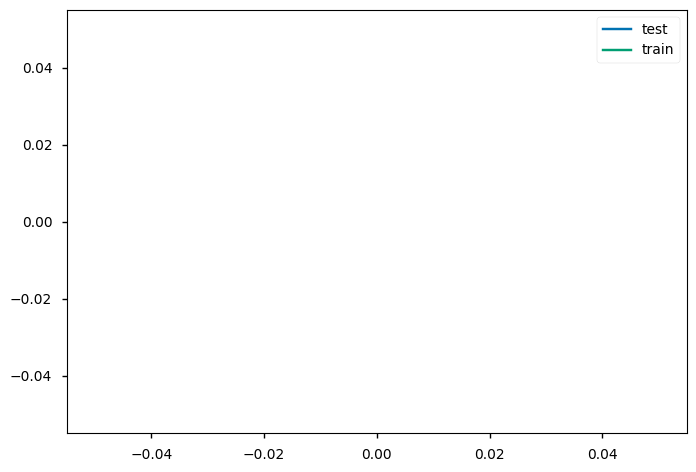

In [ ]:
plt.plot(eval_history_test, label='Test')
plt.plot(eval_history_train, label='Train')
plt.set_xlabel("Iterations")
plt.set_ylabel("Accuracy")
plt.legend()
plt.title("Performance of FB on Train and Test layouts across tasks")

{'actions': (100,), 'layout_type': (100, 10), 'next_observations': (100, 2), 'observations': (100, 2), 'terminals': (100,)}
{'actions': (100,), 'layout_type': (100, 10), 'next_observations': (100, 2), 'observations': (100, 2), 'terminals': (100,)}


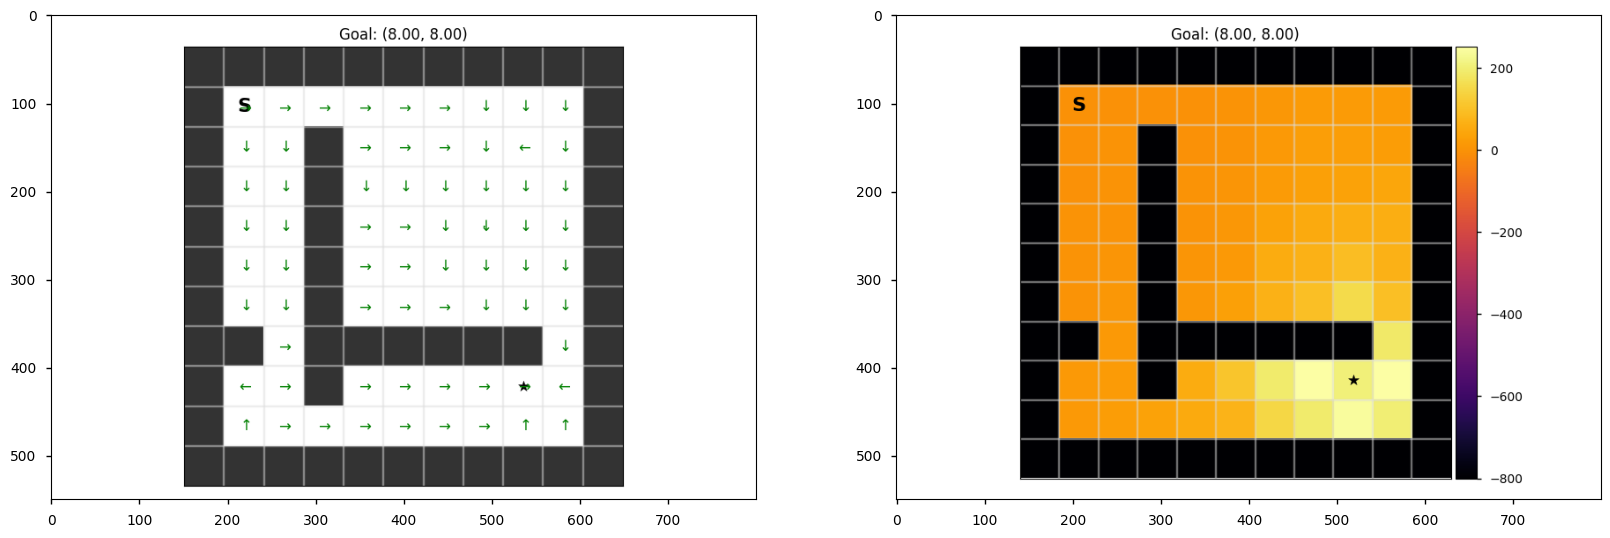

In [9]:
env = FourRoomsMazeEnv(Maze(seed=4213, maze_type='fourrooms_random_layouts'), max_steps=fb_config['agent']['context_len']) # ood
# env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
pred_policy_img = visualize_policy(env, layout_type=0, task_num=4)

ax[0].imshow(pred_policy_img)
pred_value_img = visualize_value_image(env, layout_type=0, task_num=4)
ax[1].imshow(pred_value_img)

In [16]:
from envs.env_utils import EpisodeMonitor
from utils.evaluation import evaluate_fourrooms_dynamics
from collections import defaultdict

eval_metrics = {}
overall_metrics = defaultdict(list)

for task_id in range(4): # static for 4 rooms
    for env_id in range(fb_config['agent']['number_of_meta_envs']):
        env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), max_steps=fb_config['agent']['context_len'])
        env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
        env.reset(options={"start": (1, 1)})
        dataset_inference, env = random_exploration_fourrooms(env, num_episodes=1, layout_type=0, num_mdp=fb_config['agent']['number_of_meta_envs'])
        dynamics_embedding_mean, dynamics_mean_std = fb_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None,:,None],
                                                                                    dataset_inference['next_observations'][None], train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
        dynamics_embedding=dynamics_embedding.squeeze()
        eval_info, _, _ = evaluate_fourrooms_dynamics(
                agent=fb_agent,
                dynamics_embedding=dynamics_embedding,
                env=env,
                task_id=task_id,
                config=None,
                num_eval_episodes=10,
                num_video_episodes=0,
                video_frame_skip=1,
                eval_temperature=0.0,
                eval_gaussian=None
            )
        eval_metrics.update(
            {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
        )
        for k, v in eval_info.items():
            overall_metrics[k].append(v)
            
for k, v in overall_metrics.items():
    eval_metrics[f'evaluation/overall_{k}_train'] = np.mean(v)

In [17]:
eval_metrics['evaluation/overall_episode.final_reward_train']

np.float64(0.7883333333333336)

In [18]:
eval_metrics = {}
overall_metrics = defaultdict(list)
            
for task_id in range(4):
    for env_id in range(NUM_TRAIN_LAYOUTS+40, NUM_TRAIN_LAYOUTS + 60):
        env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), max_steps=fb_config['agent']['context_len'])
        env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
        env.reset(options={"start": (1, 1)})
        dataset_inference, env = random_exploration_fourrooms(env, num_episodes=1, layout_type=0, num_mdp=NUM_TRAIN_LAYOUTS)
        dynamics_embedding_mean, dynamics_mean_std = fb_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None,:,None],
                                                                                    dataset_inference['next_observations'][None], train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
        dynamics_embedding=dynamics_embedding.squeeze()
        eval_info, _, _ = evaluate_fourrooms_dynamics(
                agent=fb_agent,
                dynamics_embedding=dynamics_embedding,
                env=env,
                task_id=task_id,
                config=None,
                num_eval_episodes=10, ##
                num_video_episodes=0,
                video_frame_skip=1,
                eval_temperature=0.0,
                eval_gaussian=None
            )
        eval_metrics.update(
            {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
            )
        for k, v in eval_info.items():
            overall_metrics[k].append(v)
            
for k, v in overall_metrics.items():
    eval_metrics[f'evaluation/overall_{k}_ood'] = np.mean(v)

In [19]:
eval_metrics['evaluation/overall_episode.final_reward_ood']

np.float64(0.40750000000000003)

{'actions': (100,), 'layout_type': (100, 10), 'next_observations': (100, 2), 'observations': (100, 2), 'terminals': (100,)}


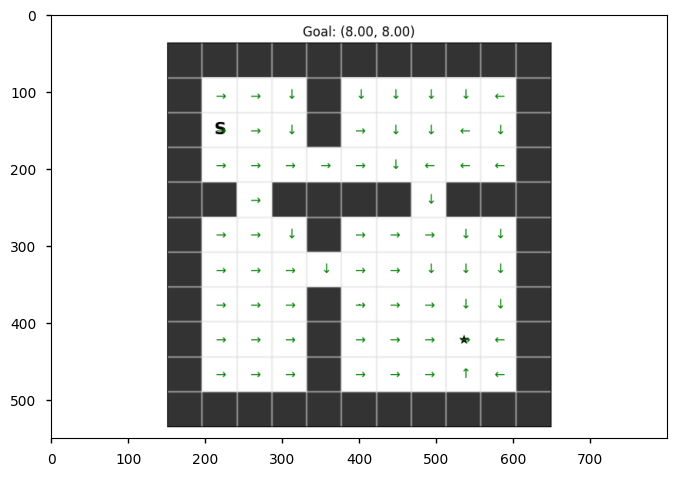

In [22]:
env = FourRoomsMazeEnv(Maze(seed=300, maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
pred_policy_img = visualize_policy(env, layout_type=1, task_num=0)
plt.imshow(pred_policy_img)